In [6]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback, get_scheduler
from evaluate import load
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch.optim as optim
import numpy as np

# Load a custom CSV file
data_files = {"train": "train_test_datasets/train_balanced.csv", "test": "train_test_datasets/test.csv"}
dataset = load_dataset("csv", data_files=data_files)

# -----------------------------------
# INITIAL INSPECTION
# -----------------------------------

# Inspect the first few samples
print(dataset["train"][0])

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") #NOTE: Using base model. Increase size for better performance
sample_text = "The purpose of this organization is to provide community services."
tokens = tokenizer(sample_text, padding='max_length', truncation=True, max_length=128)
print(tokens)

def tokenize_function(examples):
    return tokenizer(examples["mission"], padding='max_length', truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
print(tokenized_datasets["train"][0])

labels = dataset['train']['label']
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
print(class_weights)

Generating train split: 3718 examples [00:00, 369501.05 examples/s]
Generating test split: 900 examples [00:00, 59340.30 examples/s]


{'mission': 'home to home provides monitored child custody exchanges to protect children from potential instances of domestic violence and emtional trauma', 'label': 0, 'reason': 'The mission focuses on providing monitored child custody exchanges and addressing domestic violence, which are secular activities.'}
{'input_ids': [101, 1996, 3800, 1997, 2023, 3029, 2003, 2000, 3073, 2451, 2578, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Map: 100%|██████████| 900/900 [00:00<00:00, 13032.13 examples/s]


{'mission': 'home to home provides monitored child custody exchanges to protect children from potential instances of domestic violence and emtional trauma', 'label': 0, 'reason': 'The mission focuses on providing monitored child custody exchanges and addressing domestic violence, which are secular activities.', 'input_ids': [101, 2188, 2000, 2188, 3640, 17785, 2775, 9968, 15800, 2000, 4047, 2336, 2013, 4022, 12107, 1997, 4968, 4808, 1998, 7861, 3508, 2389, 12603, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# -----------------------------------
# SETTING MODEL AND LABELS
# -----------------------------------

# Load model with binary classification head
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
print(model.config)
optimizer = optim.AdamW(model.parameters())

# Freeze all layers except the classifier --> this optimizes the weights of the head layers
for param in model.bert.parameters(): # encoder parameters
    param.requires_grad = False

# Keep only the classification head trainable
for param in model.classifier.parameters():
    param.requires_grad = True

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Trainable parameters: 1538


In [10]:
# -----------------------------------
# SETTING PARAMETERS FOR TRAINING
# -----------------------------------

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    save_total_limit=2,
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=500,
    fp16=True,
    # push_to_hub=True
)

In [11]:
# -----------------------------------
# TRAINING AND EVALUATION
# -----------------------------------

metric = load('f1') # accuracy does not work great for imbalanced datasets, f1 is better

def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    preds = eval_pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # This ensures that each batch is dynamically padded to the longest seq. in the batch

num_training_steps = len(tokenized_datasets["train"]) // training_args.per_device_train_batch_size
num_training_steps *= training_args.num_train_epochs

scheduler = get_scheduler( # this helps start with a small learning rate, increase it gradually and decay afterwards
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps # number of batches * number of epochs
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics
)



trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2)) # early stop to reach peak performance and avoid overfitting
trainer.train()
trainer.save_model("./my_model")

results = trainer.evaluate()
print(results)

C:\Users\rqg886\AppData\Local\Temp\ipykernel_15948\2487327480.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\rqg886\Desktop\BINARY-CLASSIFIER-MISSIONS\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.447589,0.880000,0.443299,0.434343,0.452632
2,No log,0.488649,0.868889,0.516393,0.422819,0.663158
3,0.613900,0.378549,0.913333,0.561798,0.602410,0.526316
4,0.613900,0.436010,0.906667,0.600000,0.547826,0.663158


c:\Users\rqg886\Desktop\BINARY-CLASSIFIER-MISSIONS\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\rqg886\Desktop\BINARY-CLASSIFIER-MISSIONS\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\rqg886\Desktop\BINARY-CLASSIFIER-MISSIONS\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\rqg886\Desktop\BINARY-CLASSIFIER-MISSIONS\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used

{'eval_loss': 0.37854906916618347, 'eval_accuracy': 0.9133333333333333, 'eval_f1': 0.5617977528089888, 'eval_precision': 0.6024096385542169, 'eval_recall': 0.5263157894736842, 'eval_runtime': 39.7312, 'eval_samples_per_second': 22.652, 'eval_steps_per_second': 1.435, 'epoch': 4.0}


c:\Users\rqg886\Desktop\BINARY-CLASSIFIER-MISSIONS\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

           0       0.94      0.96      0.95       805
           1       0.60      0.53      0.56        95

    accuracy                           0.91       900
   macro avg       0.77      0.74      0.76       900
weighted avg       0.91      0.91      0.91       900



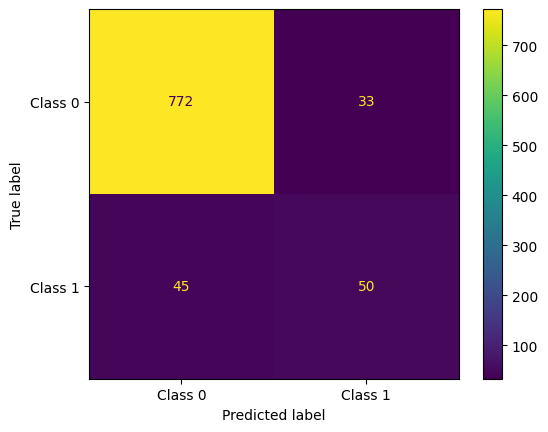

In [14]:


# -----------------------------------
# CLASSIFICATION REPORT AND CONFUSION MATRIX
# -----------------------------------

# Generate predictions
predictions = trainer.predict(tokenized_datasets["test"])
predicted_labels = predictions.predictions.argmax(axis=-1)

# Classification report
print(classification_report(tokenized_datasets["test"]["label"], predicted_labels))

# Confusion matrix
cm = confusion_matrix(tokenized_datasets["test"]["label"], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot();

In [15]:
for idx, (pred, label) in enumerate(zip(predicted_labels, tokenized_datasets["test"]["label"])):
    if pred != label:
        print(f"Index: {idx}, Predicted: {pred}, Actual: {label}")
        print(tokenized_datasets["test"][idx]["mission"])

Index: 3, Predicted: 0, Actual: 1
committed to providing a holistic learning community which encourages the growth of mind body and spirit and which is actively involved in the local and global community
Index: 23, Predicted: 0, Actual: 1
the purpose of taryag legacy foundation inc is to enhance the awareness of children and adults of the importance of the torah and mitzvoth and to educate and encourage its study through the publication of an encyclopedia and torah cards
Index: 43, Predicted: 0, Actual: 1
food and clothing to needy individuals
Index: 68, Predicted: 1, Actual: 0
our mission is
Index: 72, Predicted: 0, Actual: 1
public charitable organization to provide spiritual guidance as well as physical help and train the less fortunate to use their god's given talents enabling them to become contributing members in their community and achieve excellence the organization provides help through the following services1 counseling center 2 health and dental care 3 foodprogram 4 small gr